# Metrics

# Loading libraries

In [1]:
%pip install datasets nltk spacy wordfreq language-tool-python textstat cffi

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
!python -m spacy download en_core_web_sm

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB 1.4 MB/s eta 0:00:10
     --------------------------------------- 0.1/12.8 MB 825.8 kB/s eta 0:00:16
      --------------------------------------- 0.2/12.8 MB 1.2 MB/s eta 0:00:11
      --------------------------------------- 0.2/12.8 MB 1.0 MB/s eta 0:00:13
      --------------------------------------- 0.3/12.8 MB 1.3 MB/s eta 0:00:10
     - -------------------------------------- 0.5/12.8 MB 1.9 MB/s eta 0:00:07
     -- ------------------------------------- 0.8/12.8 MB 2.4 MB/s eta 0:00:06
     --- ------------------------------------ 1.2/12.8 MB 3.2 MB/s eta 0:00:04
     ---- ----------------------------------- 1.5/12.8 MB 3.4 MB/s eta 0:00:04
     ------- -------------------------------- 2.3/12.8 MB 5.2 MB/s eta 0:00:03
     ------- -------------------------------- 2.5/12.8 MB 5.0 MB/s eta 0:00:03
     ---------- ----------------------------- 3.4/12.8 MB 


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [67]:
import nltk

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Nickolaus\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Nickolaus\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [3]:
!pip install matplotlib


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [17]:
import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm

# Loading DS

In [70]:
LANGUAGE = 'en'
LANGUAGE_FULL = 'english'

In [7]:
from datasets import load_dataset, load_from_disk

# dataset = load_dataset('BAAI/Infinity-Instruct', '3M', split='train[:1%]')
dataset = load_from_disk("infinity_instruct")
print(dataset[0])

{'id': 0, 'conversations': [{'from': 'human', 'value': 'Write a PHP program to flatten a multi-dimensional array, but without using any built-in functions or methods for flattening arrays. Additionally, ensure that the program can handle arrays with a depth of up to 10 levels.'}, {'from': 'gpt', 'value': "Here's a PHP program to flatten a multi-dimensional array without using any built-in functions or methods for flattening arrays:\n\n```php\n<?php\n\nfunction flattenArray($arr) {\n    $result = [];\n    \n    foreach ($arr as $value) {\n        if (is_array($value)) {\n            $nestedArray = flattenArray($value);\n            foreach ($nestedArray as $nestedValue) {\n                $result[] = $nestedValue;\n            }\n        } else {\n            $result[] = $value;\n        }\n    }\n    \n    return $result;\n}\n\n// Test the function\n$multiDimensionalArray = [1, 2, [3, 4, [5, 6, [7, 8, [9, 10]]]]];\n$flattenedArray = flattenArray($multiDimensionalArray);\n\nprint_r($fla

In [2]:
dataset.save_to_disk("infinity_instruct")
print("Saved locally")

Saving the dataset (1/1 shards): 100%|██████████| 34635/34635 [00:00<00:00, 236639.18 examples/s]

Saved locally


# Preprocessing

In [ ]:
texts = []
for item in tqdm(dataset, desc="Processing dataset"):
    for conv in item['conversations']:
        if conv['from'] == 'human':
            texts.append(conv['value'])

Processing dataset: 100%|██████████| 34635/34635 [00:02<00:00, 14406.28it/s]


In [9]:
print(len(texts))

51847


In [10]:
texts[0]

'Write a PHP program to flatten a multi-dimensional array, but without using any built-in functions or methods for flattening arrays. Additionally, ensure that the program can handle arrays with a depth of up to 10 levels.'

In [11]:
full_text = "\n".join(texts)

# Computing

In [12]:
metrics_res = {}

## Lexical

### Word-frequency list

In [13]:
from collections import Counter
from wordfreq import word_frequency

words = full_text.split()
word_counts = Counter(words)

zipf_scores = {word: word_frequency(word, LANGUAGE) for word in word_counts}
print(word_counts.most_common(10))

[('the', 142489), ('to', 68741), ('and', 68372), ('a', 67634), ('of', 67168), ('in', 39507), ('is', 35553), ('for', 27584), ('that', 24544), ('with', 17840)]


In [76]:
def compute_difficulty(text):
    words = text.split()
    score = 0
    for word in words:
        word_freq = zipf_scores[word]
        score += 1 / (word_freq if word_freq > 0 else 1e-6)
    return score

metrics_res['word_frequency'] = [compute_difficulty(text) for text in tqdm(texts, desc="Computing difficulty")]

Computing difficulty: 100%|██████████| 51847/51847 [00:00<00:00, 76300.07it/s]


51847


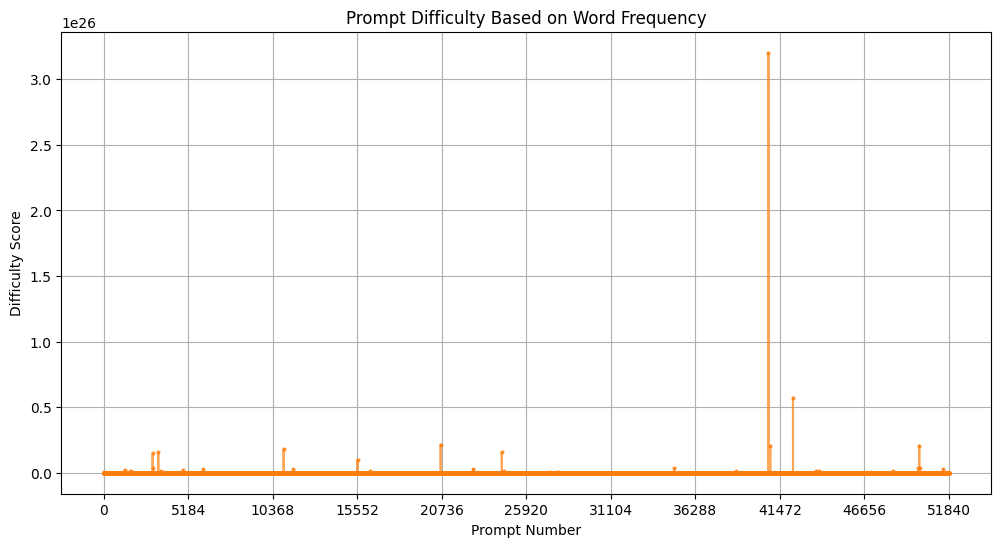

In [77]:
scores = [(index, score) for index, score in enumerate(metrics_res['word_frequency'])]
# indicies, scores = zip(*scores) if scores else ([], [])
print(len(scores))

plt.figure(figsize=(12, 6))
plt.plot(range(len(scores)), scores, marker='o', linestyle='-', markersize=2, alpha=0.7)
plt.xlabel("Prompt Number")
plt.ylabel("Difficulty Score")
plt.title("Prompt Difficulty Based on Word Frequency")
plt.xticks(np.arange(0, len(scores), step=max(1, len(scores)//10)))
plt.grid(True)

plt.show()

In [78]:
def print_most_difficult(scores):
    most_difficult = (sorted(scores, key=lambda x : x[1], reverse=True))[:3]
    for diff in most_difficult:
        print(diff[0], end=" ")
    print()

    for idx, diff in enumerate(most_difficult):
        print("---", idx + 1, "example (", diff[1], "):")
        print(texts[diff[0]])
        print("------\n")

In [79]:
print_most_difficult(scores)

40772 42278 20673 
--- 1 example ( 3.202530394385687e+26 ):
Please focus on the algorithm of this problem and provide code in Haskell:
Given an integer `n` represented as a string, return _the smallest **good base** of_ `n`.

We call `k >= 2` a **good base** of `n`, if all digits of `n` base `k` are `1`'s.

**Example 1:**

**Input:** n =  "13 "
**Output:**  "3 "
**Explanation:** 13 base 3 is 111.

**Example 2:**

**Input:** n =  "4681 "
**Output:**  "8 "
**Explanation:** 4681 base 8 is 11111.

**Example 3:**

**Input:** n =  "1000000000000000000 "
**Output:**  "999999999999999999 "
**Explanation:** 1000000000000000000 base 999999999999999999 is 11.

**Constraints:**

*   `n` is an integer in the range `[3, 1018]`.
*   `n` does not contain any leading zeros.
------

--- 2 example ( 5.721393039048795e+25 ):
##1801##C: Canisal cryptography

problem

Ebi-chan was given the string C obtained by encrypting a non-negative integer D with "canisal cipher". This cipher replaces each number in de

### Identify stop words

In [80]:
from nltk.corpus import stopwords

stop_words = set(stopwords.words(LANGUAGE_FULL))

def compute_difficulty_excluding_stopwords(text):
    words = text.split()
    score = 0
    for word in words:
        # Skip stop-words
        if word.lower() in stop_words:
            continue
        # Get word frequency from Zipf's law
        word_freq = zipf_scores.get(word, 0)
        # Add to score (avoid division by zero with a small number)
        score += 1 / (word_freq if word_freq > 0 else 1e-6)
    return score

metrics_res['stopwords'] = [
    compute_difficulty_excluding_stopwords(text) for text in tqdm(texts, desc="Computing difficulty (no stop-words)")
]

Computing difficulty (no stop-words): 100%|██████████| 51847/51847 [00:00<00:00, 55980.26it/s]


Total prompts: 51847


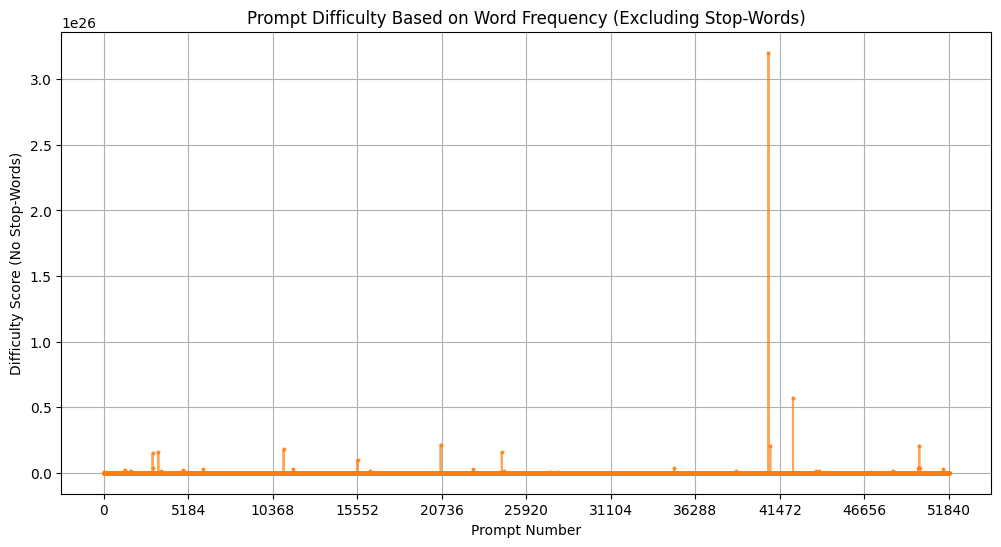

In [81]:
scores = [(index, score) for index, score in enumerate(metrics_res['stopwords'])]
print(f"Total prompts: {len(scores)}")

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(range(len(scores)), scores, marker='o', linestyle='-', markersize=2, alpha=0.7)
plt.xlabel("Prompt Number")
plt.ylabel("Difficulty Score (No Stop-Words)")
plt.title("Prompt Difficulty Based on Word Frequency (Excluding Stop-Words)")
plt.xticks(np.arange(0, len(scores), step=max(1, len(scores)//10)))
plt.grid(True)
plt.show()

In [82]:
print_most_difficult(scores)

40772 42278 20673 
--- 1 example ( 3.202530394385687e+26 ):
Please focus on the algorithm of this problem and provide code in Haskell:
Given an integer `n` represented as a string, return _the smallest **good base** of_ `n`.

We call `k >= 2` a **good base** of `n`, if all digits of `n` base `k` are `1`'s.

**Example 1:**

**Input:** n =  "13 "
**Output:**  "3 "
**Explanation:** 13 base 3 is 111.

**Example 2:**

**Input:** n =  "4681 "
**Output:**  "8 "
**Explanation:** 4681 base 8 is 11111.

**Example 3:**

**Input:** n =  "1000000000000000000 "
**Output:**  "999999999999999999 "
**Explanation:** 1000000000000000000 base 999999999999999999 is 11.

**Constraints:**

*   `n` is an integer in the range `[3, 1018]`.
*   `n` does not contain any leading zeros.
------

--- 2 example ( 5.721393039048795e+25 ):
##1801##C: Canisal cryptography

problem

Ebi-chan was given the string C obtained by encrypting a non-negative integer D with "canisal cipher". This cipher replaces each number in de

## Syntactic

### Number of clauses

In [ ]:
...

### Dependency tree

In [ ]:
...

### Polysemous words 

In [ ]:
...

## Semantic

### Contextual ambiguity

In [ ]:
...

## Grammatical correctness

### Checking errors

In [ ]:
...

### Part of speech distribution

In [ ]:
...

## Readability score

### Flesch-Kincaid score

In [ ]:
...

### Gunning Fog Index

In [ ]:
...

### Dale-Chall Readability Score

In [ ]:
...